In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from statsforecast.utils import AirPassengersDF
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive, SeasonalNaive,
    RandomWalkWithDrift,
    WindowAverage,
    SeasonalWindowAverage
)

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss

from utilsforecast.losses import mae, rmse
from utilsforecast.evaluation import evaluate



os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

In [26]:
df = AirPassengersDF
df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


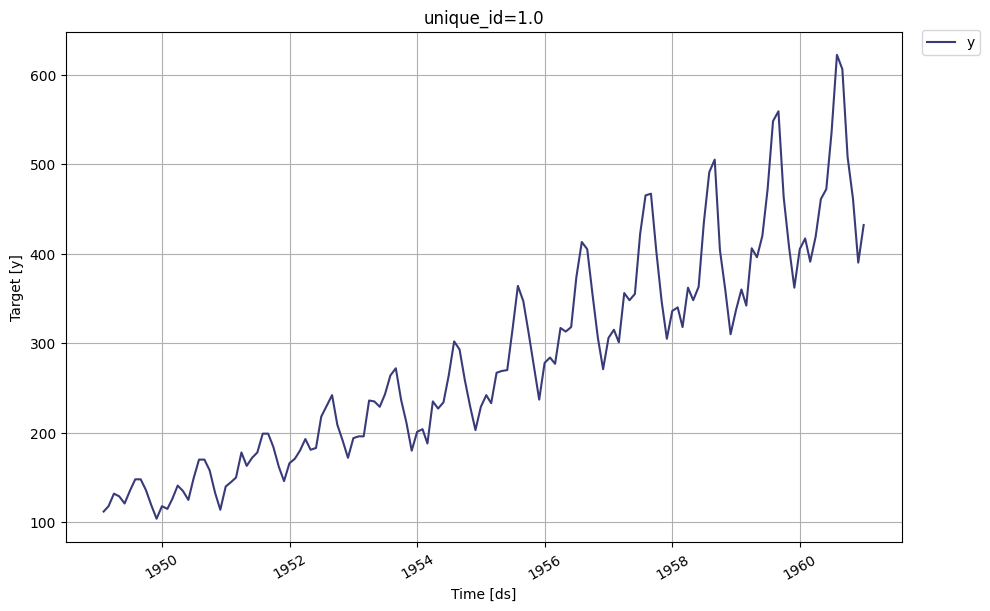

In [27]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(6)
f

### Baselines

- historic_average
- naive
- seasonal_naive
- random_walk_with_drift
- window_average
- seasonal_window_average

In [28]:
sf = StatsForecast(
    models = [HistoricAverage(), Naive(), SeasonalNaive(season_length=12), RandomWalkWithDrift(),
              WindowAverage(window_size=6, alias='WindowAverage6'),
              WindowAverage(window_size=12, alias='WindowAverage12'),
              WindowAverage(window_size=24, alias='WindowAverage24'),
              SeasonalWindowAverage(season_length=12, window_size=2, alias='SeasWA2'),
              SeasonalWindowAverage(season_length=12, window_size=3, alias='SeasWA3'),
              SeasonalWindowAverage(season_length=12, window_size=4, alias='SeasWA4')],
    freq = 'ME'
)

sf.fit(df)

# h = forecast horizon 24 ME => 2 years
forecast_df = sf.predict(h=24)
forecast_df.tail()

,unique_id,ds,HistoricAverage,Naive,SeasonalNaive,RWD,WindowAverage6,WindowAverage12,WindowAverage24,SeasWA2,SeasWA3,SeasWA4
19,1.0,1962-08-31,280.298611,432.0,606.0,476.755245,503.166667,476.166667,452.25,582.5,556.666667,534.25
20,1.0,1962-09-30,280.298611,432.0,508.0,478.993007,503.166667,476.166667,452.25,485.5,458.333333,444.75
21,1.0,1962-10-31,280.298611,432.0,461.0,481.230769,503.166667,476.166667,452.25,434.0,409.000000,393.50
22,1.0,1962-11-30,280.298611,432.0,390.0,483.468531,503.166667,476.166667,452.25,376.0,354.000000,341.75
23,1.0,1962-12-31,280.298611,432.0,432.0,485.706294,503.166667,476.166667,452.25,418.5,391.333333,377.50


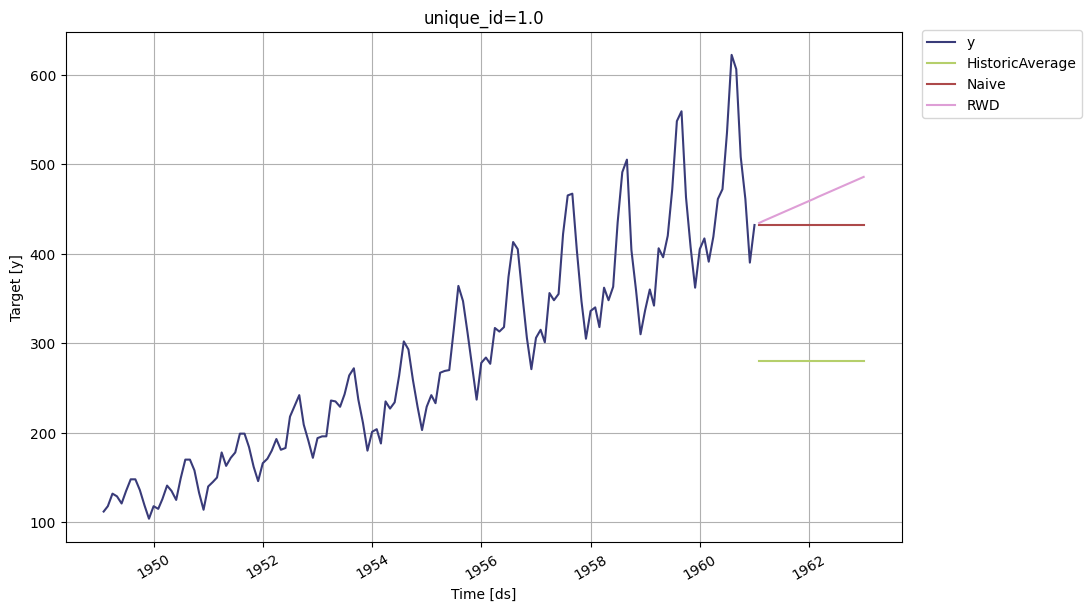

In [29]:
# HistoricAverage | Naive | RandomWalkWithDrift

f = sf.plot(df, forecast_df, models=['HistoricAverage', 'Naive', 'RWD'])
f.set_figwidth(9)
f.set_figheight(6)
f

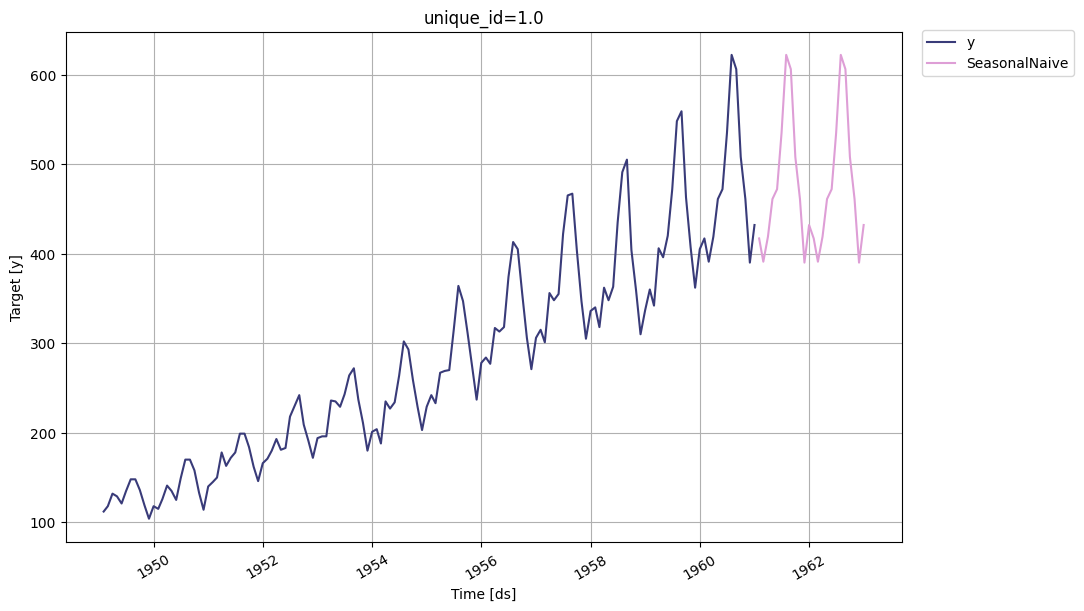

In [30]:
# Seasonal Naive

f = sf.plot(df, forecast_df, models=['SeasonalNaive'])
f.set_figwidth(9)
f.set_figheight(6)
f

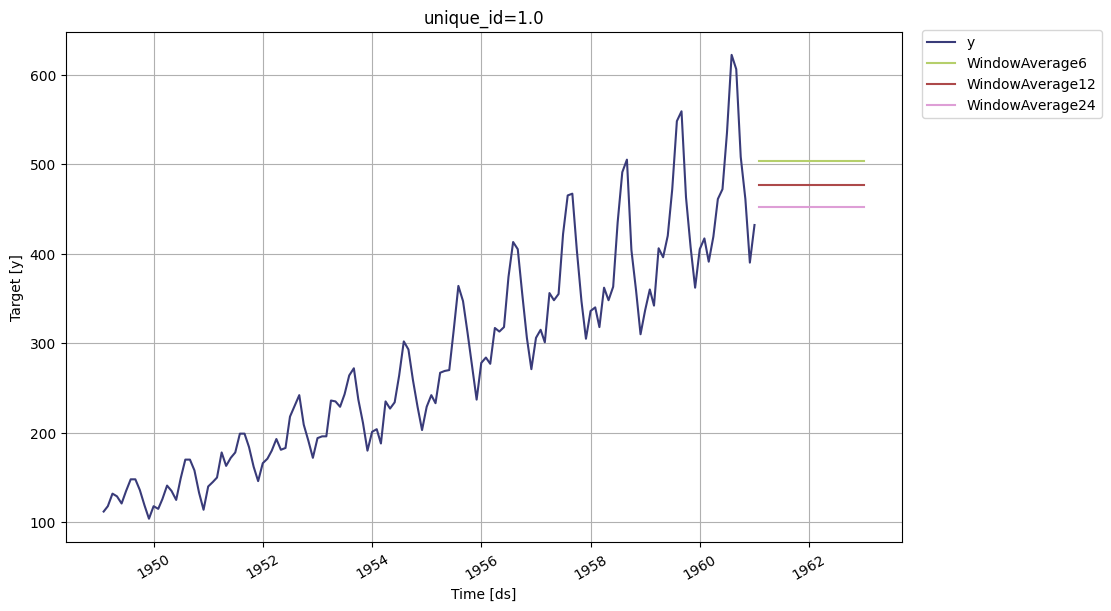

In [31]:
# Window Average 6, 12, 24 months

f = sf.plot(df, forecast_df, models=['WindowAverage6', 'WindowAverage12', 'WindowAverage24'])
f.set_figwidth(9)
f.set_figheight(6)
f

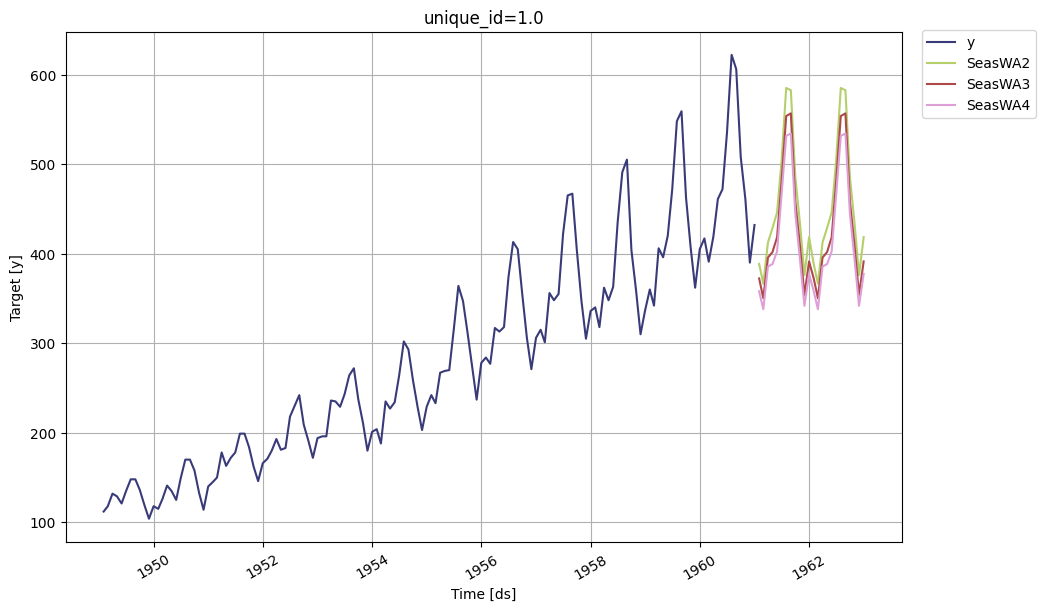

In [ ]:
# Seasonal Window Average 2, 3, 4 Seasons, 1 season = 12 months

f = sf.plot(df, forecast_df, models=['SeasWA2', 'SeasWA3', 'SeasWA4'])
f.set_figwidth(9)
f.set_figheight(6)
f

### Point Forecast and Prediction Interval

- single best guess
- range[low, high]: of given probability

In [52]:
sf1 = StatsForecast(
    models = [SeasonalNaive(season_length=12)],
    freq = 'ME'
)

sf1.fit(df)

# each forecasted month gets its own 80% uncertainty band.
forecast_df = sf1.predict(h=24, level=[80])
forecast_df.tail()

,unique_id,ds,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
19,1.0,1962-08-31,606.0,540.181794,671.818206
20,1.0,1962-09-30,508.0,442.181794,573.818206
21,1.0,1962-10-31,461.0,395.181794,526.818206
22,1.0,1962-11-30,390.0,324.181794,455.818206
23,1.0,1962-12-31,432.0,366.181794,497.818206


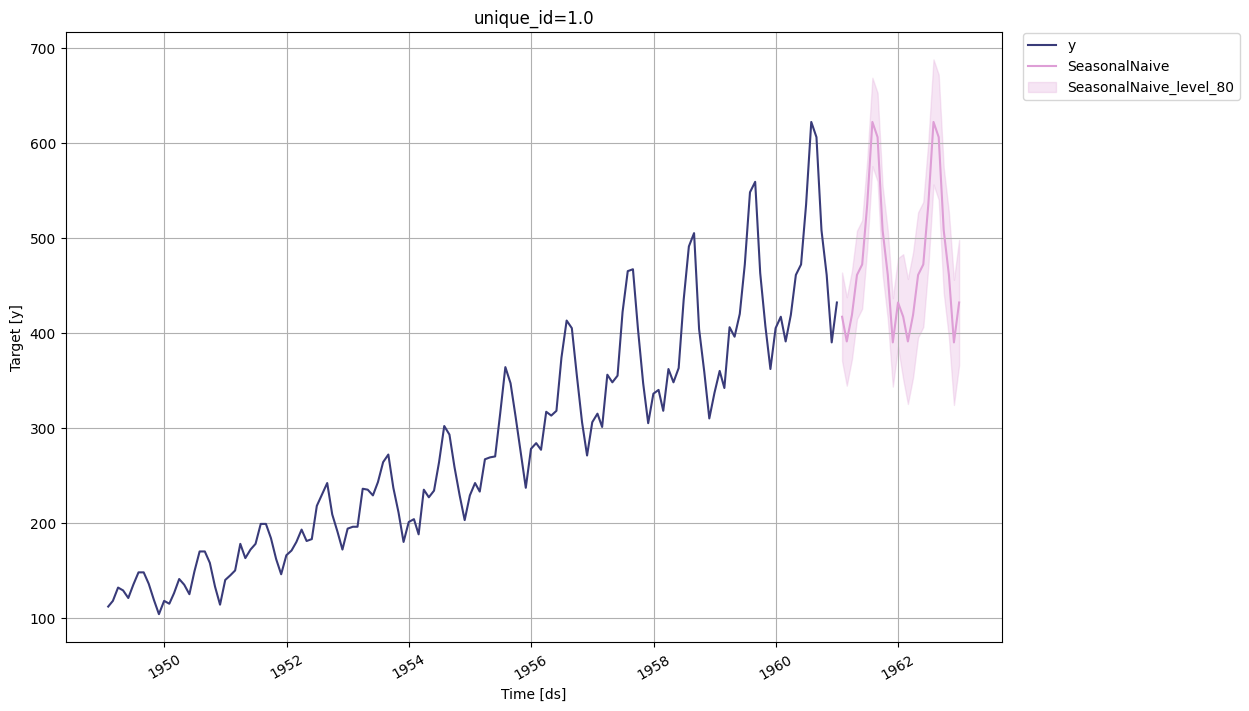

In [53]:
f = sf1.plot(df, forecast_df, level=[80])
f.set_figwidth(10)
f.set_figheight(7)
f

In [ ]:
res = pd.DataFrame({
    'ds': df.ds,
    'fitted': sf1.fitted_[0,0].model_.get("fitted"),
    'actual': df.y
})

res['residuals'] = res.actual - res.fitted
res

,ds,fitted,actual,residuals
0,1949-01-31,NaN,112.0,NaN
1,1949-02-28,NaN,118.0,NaN
2,1949-03-31,NaN,132.0,NaN
3,1949-04-30,NaN,129.0,NaN
4,1949-05-31,NaN,121.0,NaN
...,...,...,...,...
139,1960-08-31,559.0,606.0,47.0
140,1960-09-30,463.0,508.0,45.0
141,1960-10-31,407.0,461.0,54.0
142,1960-11-30,362.0,390.0,28.0


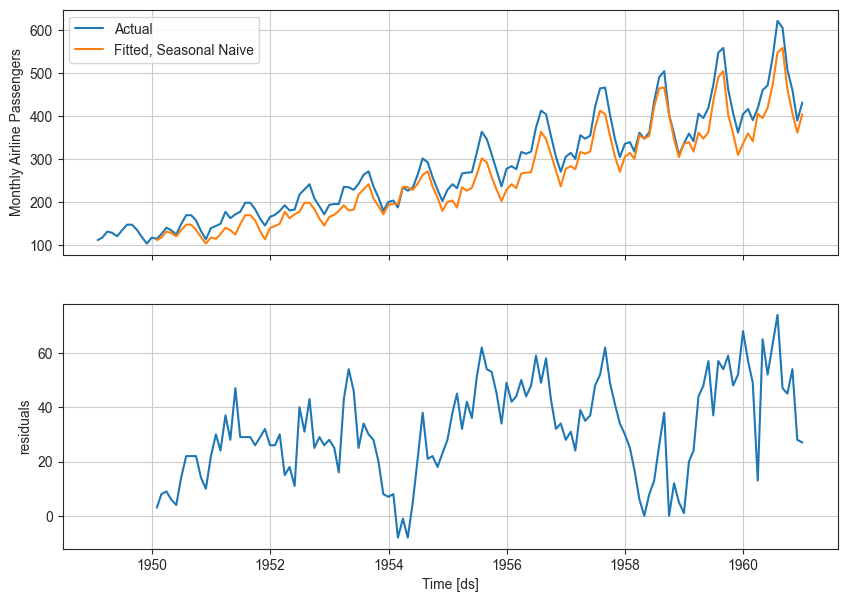

In [55]:
sns.set_style("ticks",{'axes.grid' : True})

fig, axs = plt.subplots(nrows=2, figsize=(10,7), sharex=True)
sns.lineplot(x='ds', y='actual', data=res, label='Actual', ax=axs[0])
sns.lineplot(x='ds', y='fitted', data=res, label='Fitted, Seasonal Naive', ax=axs[0])
sns.lineplot(x='ds', y='residuals', data=res, ax=axs[1])
axs[0].set_xlabel('')
axs[0].set_ylabel('Monthly Airline Passengers')
axs[1].set_xlabel('Time [ds]')
plt.show()

#### ResidualPlotAnalysis

- non-constant variance (increases overtime)
- try log transformations to stabilize variance
- the residuals should behave like whitenoise

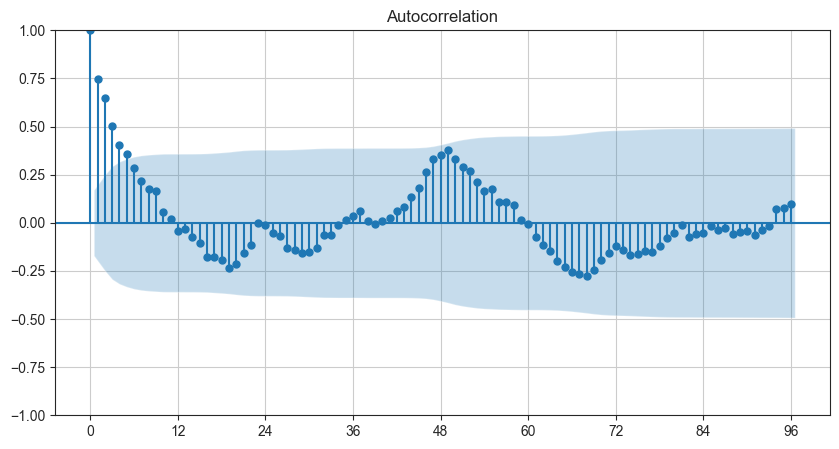

In [64]:
plt.rc("figure", figsize=(10,5))

# skip first 12 months
plot_acf(res.residuals[12:], lags=96)
plt.xticks(range(0, 97, 12))
plt.show()

#### ACF Plot Analysis

- strong positive correlation gradually declining (Lags 0-12)
- seasonality patterns (Lag 48 and 72)
- Sinusodial patterns

### Test Statistically

- `Ljung–Box test`: checks residuals are just whitenoise or not

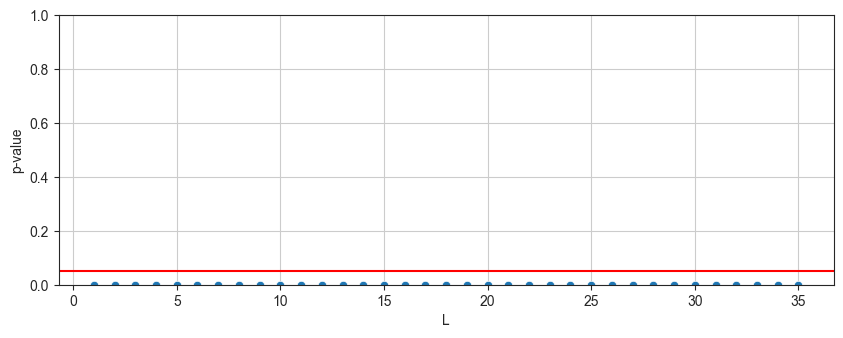

In [ ]:
# return_df = True => p-value
ps = sm.stats.acorr_ljungbox(res.residuals[12:], lags=list(range(1,36)), return_df=True)

plt.rc("figure", figsize=(10,3.5))
# p-value vs lag
# one-dot = one Ljung-box test
f = sns.scatterplot(ps, x=ps.index, y=ps.lb_pvalue)
f.set_ylim(0, 1)
plt.xlabel('L')
plt.ylabel('p-value')

# standard significance threshold
plt.axhline(y=0.05, color='red')
plt.show()

Standard p-value: `0.05`

if p-value is above threshold
- fail to reject null
- residuals ~= white-noise

else
- reject null
- residuals still autocorrelated


`Seasonal is not sufficient`

<br>

### KPSS Testing

- `Null hypothesis (H0)`: the series is stationary
- `Alternative (H1)`: the series is non-stationary

In [69]:
kpss(res.residuals[12:])

(np.float64(0.5335960256471981),
 np.float64(0.034099994223604026),
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

- KPSS statistic = 0.5336
- p-value        = 0.0341
- lags used      = 6
- critical vals  = {10%: 0.347, 5%: 0.463, 2.5%: 0.574, 1%: 0.739}

<br>

#### Cross-Validation Temporal Data

- which model is better

Train --------| Forecast 12\
Train ------------| Forecast 12\
Train ------------------| Forecast 12

In [70]:
# rolling-origin (time-series cross validation)
# h=12           (12 months ahead forecast)
# step_size=12   (move training window 12moths each iteration)
# n_windows=3    (3 iterations)
crossvalidation_df = sf.cross_validation(
    df = df,
    h = 12,
    step_size = 12,
    n_windows = 3
  )

crossvalidation_df.head()

,unique_id,ds,cutoff,y,HistoricAverage,Naive,SeasonalNaive,RWD,WindowAverage6,WindowAverage12,WindowAverage24,SeasWA2,SeasWA3,SeasWA4
0,1.0,1958-01-31,1957-12-31,340.0,230.898148,336.0,315.0,338.093458,387.333333,368.416667,348.333333,299.5,280.333333,261.25
1,1.0,1958-02-28,1957-12-31,318.0,230.898148,336.0,301.0,340.186916,387.333333,368.416667,348.333333,289.0,270.333333,249.75
2,1.0,1958-03-31,1957-12-31,362.0,230.898148,336.0,356.0,342.280374,387.333333,368.416667,348.333333,336.5,313.333333,293.75
3,1.0,1958-04-30,1957-12-31,348.0,230.898148,336.0,348.0,344.373832,387.333333,368.416667,348.333333,330.5,310.000000,289.25
4,1.0,1958-05-31,1957-12-31,363.0,230.898148,336.0,355.0,346.467290,387.333333,368.416667,348.333333,336.5,314.333333,294.25


Train up to cutoff --> forecast next h months

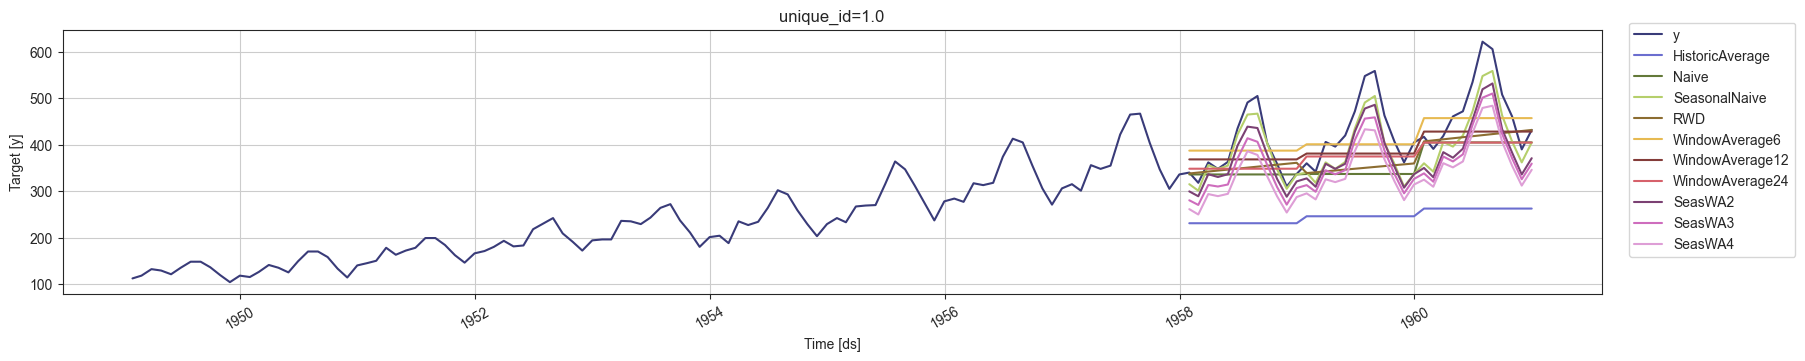

In [80]:
StatsForecast.plot(
    df,
    crossvalidation_df.drop(columns=["cutoff", "y"])
)


In [83]:
res = evaluate(crossvalidation_df, metrics=[mae, rmse], models=['HistoricAverage', 'Naive', 'SeasonalNaive', 'RWD'])
res

,unique_id,cutoff,metric,HistoricAverage,Naive,SeasonalNaive,RWD
0,1.0,1957-12-31,mae,150.101852,52.333333,12.583333,47.281931
1,1.0,1958-12-31,mae,182.425000,91.333333,47.333333,79.043417
2,1.0,1959-12-31,mae,213.674242,76.000000,47.833333,66.307888
3,1.0,1957-12-31,rmse,162.319847,76.434067,17.012250,68.876190
4,1.0,1958-12-31,rmse,194.290426,113.188633,49.254441,102.578907
5,1.0,1959-12-31,rmse,226.265671,102.976535,50.708316,92.666363
